In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer

from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from feature_engine.discretisation import EqualWidthDiscretiser
from scipy.stats import ttest_ind
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier,
    StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    accuracy_score, mean_squared_error, roc_auc_score, r2_score,
    roc_curve, auc
)
from feature_engine.outliers import Winsorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
health_data = pd.read_csv('./Dataset Ph1.csv')

In [3]:
health_data.head()

,Indexno,AGE,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,GradeofKidneydisease,AnaestypeCategory,PriorityCategory,AGEcategory,AGEcategoryOriginal,SurgRiskCategory,RaceCategory,GradeofKidneyCategory,Anemiacategorybinned,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,106656,27,MALE,0.0,none,NaN,BLANK,GA,Elective,18-29,18-29,Moderate,Chinese,#NULL!,None,#NULL!,I,yes
1,117255,19,FEMALE,NaN,none,134.076722,g1,GA,Elective,18-29,18-29,Low,Others,G1,None,<= 15.7,#NULL!,yes
2,111689,21,MALE,0.0,none,121.195820,g1,GA,Elective,18-29,18-29,Low,Chinese,G1,None,<= 15.7,II,no
3,110169,20,MALE,1.0,moderate,124.312948,g1,GA,Emergency,18-29,18-29,Moderate,Chinese,G1,Moderate/Severe,<= 15.7,IV-VI,yes
4,100897,29,MALE,0.0,none,81.442682,G2,GA,Elective,18-29,18-29,Low,Chinese,G2,None,<= 15.7,I,no


In [4]:
health_data.shape

(9998, 18)

In [5]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Indexno                9998 non-null   int64  
 1   AGE                    9998 non-null   int64  
 2   GENDER                 9998 non-null   object 
 3   RCRI score             6884 non-null   float64
 4   Anemia category        9537 non-null   object 
 5   PreopEGFRMDRD          8819 non-null   float64
 6   GradeofKidneydisease   9998 non-null   object 
 7   AnaestypeCategory      9998 non-null   object 
 8   PriorityCategory       9998 non-null   object 
 9   AGEcategory            9998 non-null   object 
 10  AGEcategoryOriginal    9998 non-null   object 
 11  SurgRiskCategory       9998 non-null   object 
 12  RaceCategory           9998 non-null   object 
 13  GradeofKidneyCategory  9998 non-null   object 
 14  Anemiacategorybinned   9998 non-null   object 
 15  RDW1

In [6]:
icu_admgt = (health_data['ICUAdmgt24h'].value_counts()/ len(health_data)) * 100

print('icu not admitted: {:.2f}%'.format(icu_admgt[0]))
print('icu admitted: {:.2f}%'.format(icu_admgt[1]))

icu not admitted: 87.60%
icu admitted: 12.40%


In [7]:
health_data.isnull().sum()

Indexno                     0
AGE                         0
GENDER                      0
RCRI score               3114
Anemia category           461
PreopEGFRMDRD            1179
GradeofKidneydisease        0
AnaestypeCategory           0
PriorityCategory            0
AGEcategory                 0
AGEcategoryOriginal         0
SurgRiskCategory            0
RaceCategory                0
GradeofKidneyCategory       0
Anemiacategorybinned        0
RDW15.7                     0
ASAcategorybinned           0
ICUAdmgt24h                 0
dtype: int64

# Data Cleansing

In [8]:
rows_with_null = health_data[health_data.isnull().any(axis=1)]
rows_with_null

,Indexno,AGE,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,GradeofKidneydisease,AnaestypeCategory,PriorityCategory,AGEcategory,AGEcategoryOriginal,SurgRiskCategory,RaceCategory,GradeofKidneyCategory,Anemiacategorybinned,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,106656,27,MALE,0.0,none,NaN,BLANK,GA,Elective,18-29,18-29,Moderate,Chinese,#NULL!,None,#NULL!,I,yes
1,117255,19,FEMALE,NaN,none,134.076722,g1,GA,Elective,18-29,18-29,Low,Others,G1,None,<= 15.7,#NULL!,yes
5,100894,29,MALE,NaN,none,106.903125,g1,GA,Elective,18-29,18-29,Low,Chinese,G1,None,<= 15.7,I,no
9,2006,21,FEMALE,0.0,none,NaN,BLANK,GA,Elective,18-29,18-29,Low,Others,#NULL!,None,<= 15.7,I,no
11,113259,21,MALE,0.0,NaN,NaN,BLANK,GA,Elective,18-29,18-29,Low,Chinese,#NULL!,#NULL!,#NULL!,I,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,23473,85,FEMALE,NaN,mild,51.541574,G3a,GA,Emergency,>=85,>=70,Moderate,Chinese,G3,Mild,<= 15.7,III,no
9980,116969,88,FEMALE,NaN,none,24.169652,G4,GA,Elective,>=85,>=70,Low,Chinese,G4-G5,None,<= 15.7,III,no
9982,36401,85,MALE,NaN,moderate,75.877640,G2,RA,Elective,>=85,>=70,Low,Chinese,G2,Moderate/Severe,>15.7,II,no
9983,28802,92,MALE,NaN,none,61.576281,G2,GA,Emergency,>=85,>=70,Moderate,Malay,G2,None,<= 15.7,IV-VI,no


In [9]:
health_data.replace('#NULL!', np.nan, inplace=True)

In [10]:
health_data = health_data.dropna()

In [11]:
health_data.shape #(9998, 18)

(6122, 18)

In [12]:
icu_admgt = (health_data['ICUAdmgt24h'].value_counts()/ len(health_data)) * 100

print('icu not admitted: {:.2f}%'.format(icu_admgt[0]))
print('icu admitted: {:.2f}%'.format(icu_admgt[1]))

icu not admitted: 88.01%
icu admitted: 11.99%


# Encoding

In [13]:
# Label Encoder

In [14]:
label_encoder = LabelEncoder()

def get_encoded_mappings(health_data, encoded_columns, label_encoder):
    mappings = {}
    for column in encoded_columns:
        original_values = health_data[column].unique()
        encoded_values = label_encoder.fit_transform(original_values)
        mappings[column] = dict(zip(original_values, encoded_values))
    return mappings

# Assuming label_encoder has already been applied to the DataFrame for the specified columns
encoded_columns = ['GENDER', 'AnaestypeCategory', 'PriorityCategory', 'RDW15.7']
mappings = get_encoded_mappings(health_data, encoded_columns, label_encoder)

# Display the mappings
for column, mapping in mappings.items():
    print(f"{column}: {mapping}")

health_data[['GENDER','AnaestypeCategory','PriorityCategory','RDW15.7']] = health_data[['GENDER','AnaestypeCategory','PriorityCategory','RDW15.7']].apply(label_encoder.fit_transform)

GENDER: {'MALE': 1, 'FEMALE': 0}
AnaestypeCategory: {'GA': 0, 'RA': 1}
PriorityCategory: {'Elective': 0, 'Emergency': 1}
RDW15.7: {'<= 15.7': 0, '>15.7': 1}


In [15]:
# Mapping

In [16]:
# Anemia category
Anemia_category_mapping = {"none": 0, "mild": 1, "moderate": 2, "severe": 3}
health_data['Anemia category'] = health_data['Anemia category'].map(Anemia_category_mapping)

# Grade of kidney disease
GradeofKidneydisease_mapping = {"g1": 1, "G2": 2, "G3a": 3.1, "G3b": 3.2, "G4": 4, "G5": 5}
health_data['GradeofKidneydisease'] = health_data['GradeofKidneydisease'].map(GradeofKidneydisease_mapping)

# Age category
AGEcategory_mapping = {"18-29": 1, "30-49": 2, "50-64": 3, "65-74": 4, "75-84": 5, ">=85": 6}
health_data['AGEcategory'] = health_data['AGEcategory'].map(AGEcategory_mapping)

# Age category original
AGEcategoryOriginal_mapping = {"18-29": 1, "30-49": 2, "50-69": 3, ">=70": 4}
health_data['AGEcategoryOriginal'] = health_data['AGEcategoryOriginal'].map(AGEcategoryOriginal_mapping)

# Surgical Risk Category
SurgRiskCategory_mapping = {"Low": 1, "Moderate": 2, "High": 3}
health_data['SurgRiskCategory'] = health_data['SurgRiskCategory'].map(SurgRiskCategory_mapping)

# Grade of kidney category
GradeofKidneyCategory_mapping = {"G1": 1, "G2": 2, "G3": 3, "G4-G5": 4}
health_data['GradeofKidneyCategory'] = health_data['GradeofKidneyCategory'].map(GradeofKidneyCategory_mapping)

# Anemia category binned
Anemiacategorybinned_mapping = {"None": 0, "Mild": 2, "Moderate/Severe": 3}
health_data['Anemiacategorybinned'] = health_data['Anemiacategorybinned'].map(Anemiacategorybinned_mapping)

# ASA category binned
ASAcategorybinned_mapping = {"I": 1, "II": 2, "III": 3, "IV-VI": 4}
health_data['ASAcategorybinned'] = health_data['ASAcategorybinned'].map(ASAcategorybinned_mapping)

# Race Category
RaceCategory_mapping = {}

# Iterate through unique values in the 'Category' column and assign an encoded value
for idx, RaceCategory in enumerate(health_data['RaceCategory'].unique()):
    RaceCategory_mapping[RaceCategory] = idx + 1

print("Race Category Mapping: ", RaceCategory_mapping)
# Map the values in the 'Category' column to the encoded values
health_data['RaceCategory'] = health_data['RaceCategory'].map(RaceCategory_mapping)

Race Category Mapping:  {'Chinese': 1, 'Others': 2, 'Indian': 3, 'Malay': 4}


In [17]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6122 entries, 2 to 9997
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Indexno                6122 non-null   int64  
 1   AGE                    6122 non-null   int64  
 2   GENDER                 6122 non-null   int32  
 3   RCRI score             6122 non-null   float64
 4   Anemia category        6122 non-null   int64  
 5   PreopEGFRMDRD          6122 non-null   float64
 6   GradeofKidneydisease   6122 non-null   float64
 7   AnaestypeCategory      6122 non-null   int32  
 8   PriorityCategory       6122 non-null   int32  
 9   AGEcategory            6122 non-null   int64  
 10  AGEcategoryOriginal    6122 non-null   int64  
 11  SurgRiskCategory       6122 non-null   int64  
 12  RaceCategory           6122 non-null   int64  
 13  GradeofKidneyCategory  6122 non-null   int64  
 14  Anemiacategorybinned   6122 non-null   int64  
 15  RDW1

In [18]:
# drop this set of features for streamlit testing 

health_data = health_data.drop(columns=['Indexno', 'AGEcategoryOriginal','GradeofKidneyCategory'
                                        ,'Anemiacategorybinned','AGEcategory'])

In [19]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6122 entries, 2 to 9997
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE                   6122 non-null   int64  
 1   GENDER                6122 non-null   int32  
 2   RCRI score            6122 non-null   float64
 3   Anemia category       6122 non-null   int64  
 4   PreopEGFRMDRD         6122 non-null   float64
 5   GradeofKidneydisease  6122 non-null   float64
 6   AnaestypeCategory     6122 non-null   int32  
 7   PriorityCategory      6122 non-null   int32  
 8   SurgRiskCategory      6122 non-null   int64  
 9   RaceCategory          6122 non-null   int64  
 10  RDW15.7               6122 non-null   int32  
 11  ASAcategorybinned     6122 non-null   int64  
 12  ICUAdmgt24h           6122 non-null   object 
dtypes: float64(3), int32(4), int64(5), object(1)
memory usage: 573.9+ KB


In [20]:
health_data.head()

,AGE,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,GradeofKidneydisease,AnaestypeCategory,PriorityCategory,SurgRiskCategory,RaceCategory,RDW15.7,ASAcategorybinned,ICUAdmgt24h
2,21,1,0.0,0,121.195820,1.0,0,0,1,1,0,2,no
3,20,1,1.0,2,124.312948,1.0,0,1,2,1,0,4,yes
4,29,1,0.0,0,81.442682,2.0,0,0,1,1,0,1,no
6,21,1,0.0,0,95.740830,1.0,0,1,1,2,0,4,yes
7,20,1,1.0,2,209.898261,1.0,0,0,1,1,1,3,yes


# Outlier handling

In [21]:
def diagnostic_plots(df, variable):
    # Set Seaborn style
    sns.set(style="whitegrid")
    
    # Create a figure with subplots
    plt.figure(figsize=(18, 8))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable],bins=20, kde=True, color='#AF6FAB')
    plt.title('Histogram')
    
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    
    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable], palette=sns.color_palette("mako")[::-1])
    plt.title('Boxplot')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plots
    plt.show()

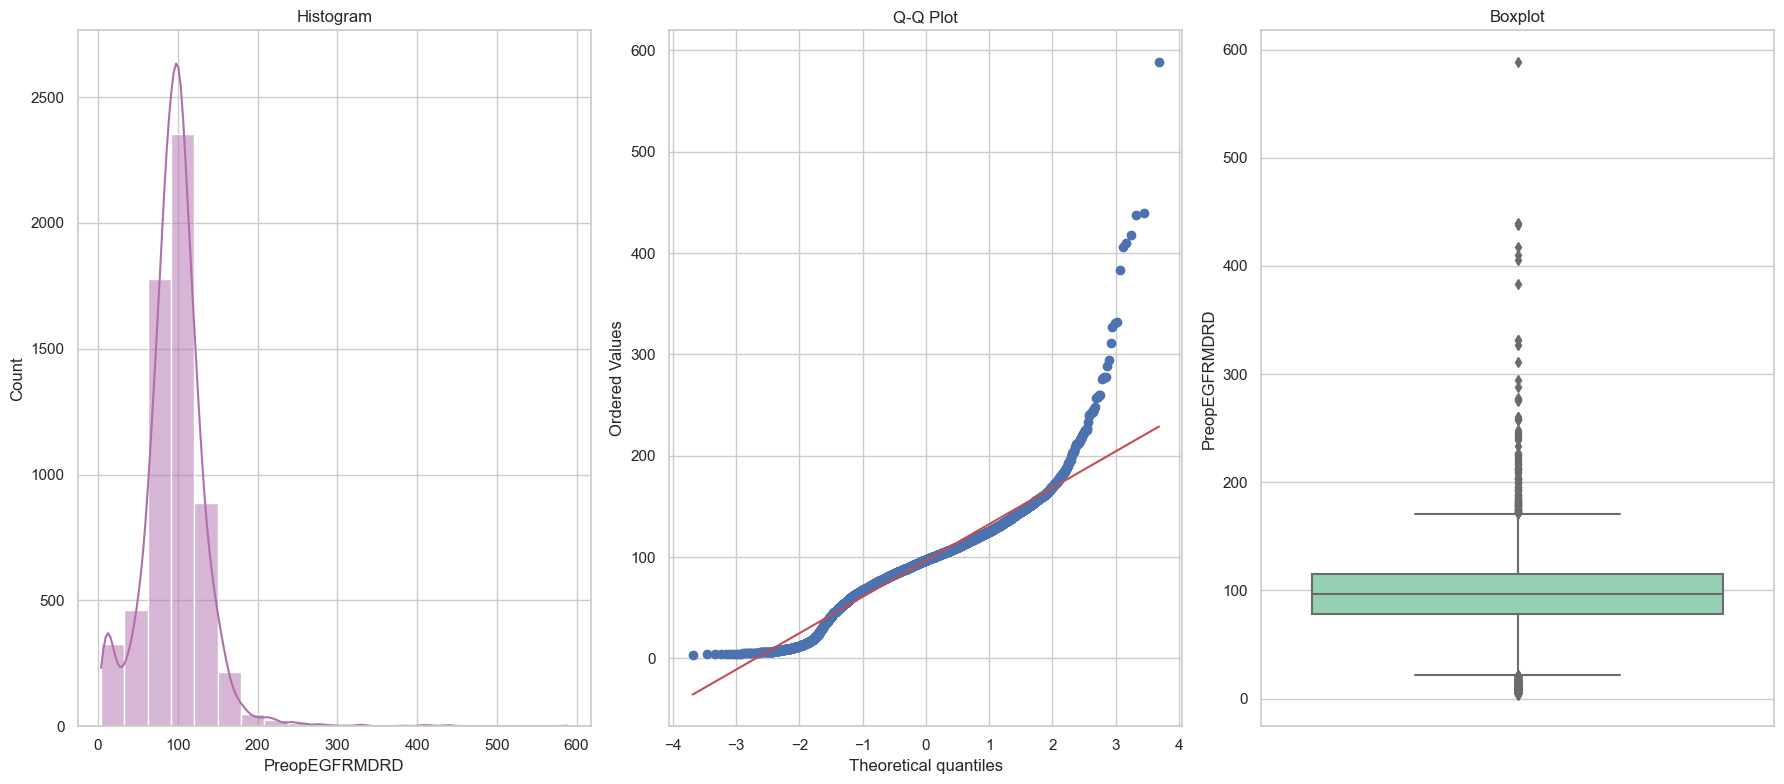

In [22]:
diagnostic_plots(health_data,'PreopEGFRMDRD')

# Winsorisation

In [23]:
windsorizer = Winsorizer(capping_method ='quantiles', 
                          tail='both', # cap left, right or both tails
                          fold =0.05,
                          variables=['PreopEGFRMDRD'])

windsorizer.fit(health_data)

health_data = windsorizer.transform(health_data)

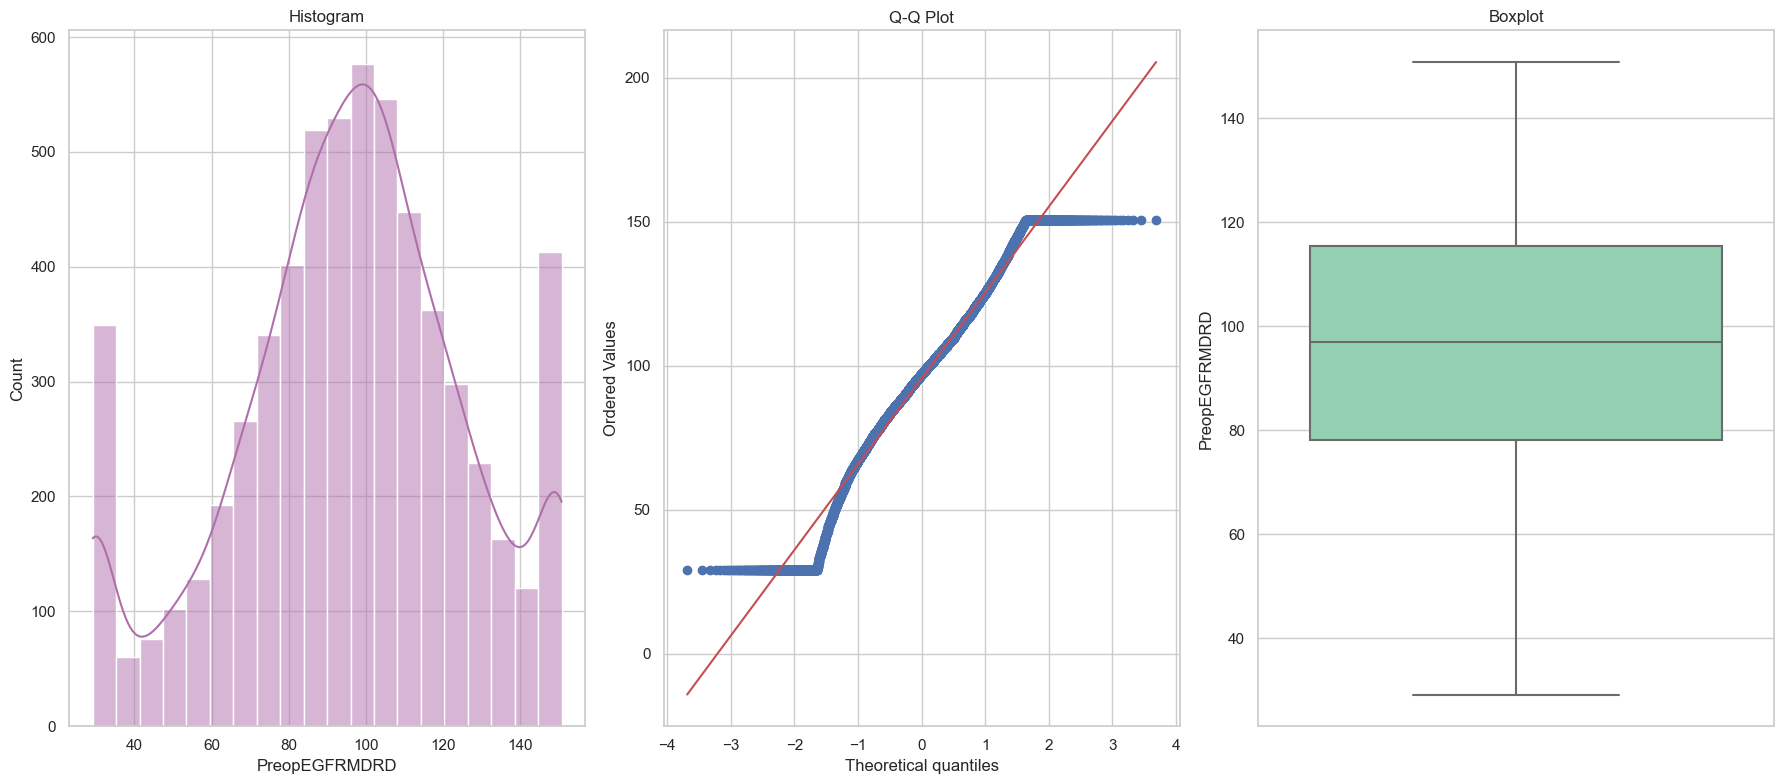

In [24]:
diagnostic_plots(health_data,'PreopEGFRMDRD')

# BALANCED TRAIN TEST SPLIT

In [25]:
# Split the HR data into train and test sets
train, test = train_test_split(health_data, test_size=0.3, random_state=42)

# Downsample the 'not_promoted' subset
not_ICUAdmgt24h_sampled = train[train['ICUAdmgt24h'] == 'no'].sample(n=2000, random_state=42)

# Combine the downsampled 'not_promoted' subset with the 'promoted' subset
train_balanced = pd.concat([not_ICUAdmgt24h_sampled, train[train['ICUAdmgt24h'] == 'yes']])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train_balanced.drop('ICUAdmgt24h', axis=1), train_balanced['ICUAdmgt24h'])

X_test = test.drop("ICUAdmgt24h", axis=1)
y_test = test["ICUAdmgt24h"] 

X_train.shape, X_test.shape

((4000, 12), (1837, 12))

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE                   4000 non-null   int64  
 1   GENDER                4000 non-null   int32  
 2   RCRI score            4000 non-null   float64
 3   Anemia category       4000 non-null   int64  
 4   PreopEGFRMDRD         4000 non-null   float64
 5   GradeofKidneydisease  4000 non-null   float64
 6   AnaestypeCategory     4000 non-null   int32  
 7   PriorityCategory      4000 non-null   int32  
 8   SurgRiskCategory      4000 non-null   int64  
 9   RaceCategory          4000 non-null   int64  
 10  RDW15.7               4000 non-null   int32  
 11  ASAcategorybinned     4000 non-null   int64  
dtypes: float64(3), int32(4), int64(5)
memory usage: 312.6 KB


In [27]:
# Make predictions on the test set
lg = LogisticRegression(solver='lbfgs', max_iter=10000)

# run enough iterations to let the model converge

# Fit the model to the training set
lg.fit(X_train,y_train)

print(lg.score(X_train, y_train), '(Train Accuracy)')
print(lg.score(X_test, y_test), '(Test Accuracy)')

predictions = lg.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

0.8205 (Train Accuracy)
0.819270549809472 (Test Accuracy)
              precision    recall  f1-score   support

          no       0.97      0.82      0.89      1617
         yes       0.38      0.83      0.52       220

    accuracy                           0.82      1837
   macro avg       0.68      0.82      0.71      1837
weighted avg       0.90      0.82      0.84      1837



### Changes Made: 
#### Dropped Features: 
- Indexno
- AGEcategoryOriginal
- GradeofKidneyCategory
- Anemiacategorybinned
- AGEcategory

#### Saved Model using Pickle Module

In [28]:
import pickle

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lg, f)

# use pickle to save the model 